### Install the Digital Twin Builder Sample Package

In [ ]:
df = spark.sql("SELECT * FROM ZavaLakehouse.what_if_analysis_results LIMIT 1000")
display(df)

In [ ]:
%pip install /lakehouse/default/Files/dtb_samples-0.2-py3-none-any.whl --quiet

### Load Digital Twin

In [ ]:
import com.microsoft.spark.fabric
from com.microsoft.spark.fabric.Constants import Constants

from dtb.client import DtbClient
from dtb.core import EntityRelationship, EntityType, EntityTypeProperty
from dtb.utilities import DtbFabricHelper, DtbGraph

dtb_item_name = "Zava_DigitalTwin" 
client = DtbClient(dtb_item_name)

df_reader = spark.read.option(Constants.DatabaseName, client.get_database_name())

fabric_helper = DtbFabricHelper(client)
dtb_instances = fabric_helper.get_data(spark,df_reader,include_instances=True,max_instances_per_entity=250, max_timeseries_per_instance=10)

dtb_graph_helper = DtbGraph(dtb_instances)
dtb_graph = dtb_graph_helper.generate_semantic_graph()

### Generate Machine Learning Features from Digital Twin

In [ ]:
from networkx import MultiDiGraph
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML, display
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from dtb.utilities import DtbMLHelper

entity =  "PerformanceMetric"
entity_properties = ["metricId","avgHumidity","comfortScore","peakPressure","tempDelta"]
linked_entities = ["PerformanceMetric","Product","Material","Environment","ActivityType", "ActivitySession"]

ml_helper = DtbMLHelper()

ml_feature_df = ml_helper.get_zava_ml_features(dtb_graph_helper, dtb_graph, entity, entity_properties,linked_entities)
ml_feature_df.head()

### Run What-if Analysis

###### For example, we can **simulate** how changes in material properties like **increased elasticity** or **reduced thermal conductivity**, **affect the comfort score**, especially **under varying ambient temperatures**.

In [5]:
feature_list = ["thermalConductivity", "elasticity", "ambientTemperature"]
output_list = ["comfortScore", "peakPressure", "avgHumidity", "tempDelta"]

features = ml_helper.get_np_array(ml_feature_df,feature_list)
output_labels = ml_helper.get_np_array(ml_feature_df,[output_list[0]])

sim_data = ml_helper.run_zava_whatif_analysis(ml_feature_df,features,output_labels)

StatementMeta(, bd22830c-cc3e-4018-8297-4a24c6029c56, 11, Finished, Available, Finished)

### Visualize What-if Analysis Results

StatementMeta(, bd22830c-cc3e-4018-8297-4a24c6029c56, 12, Finished, Available, Finished)

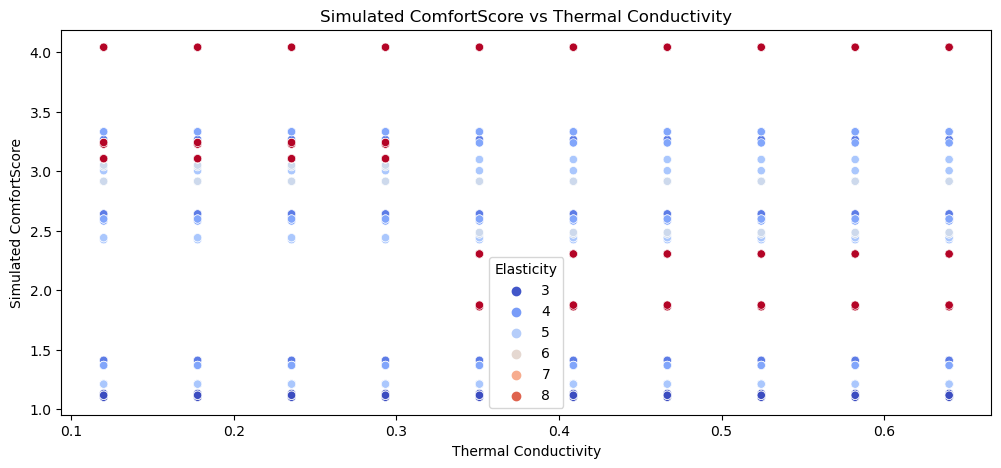

In [6]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=sim_data, x="thermalConductivity", y="SimulatedOutput", hue="elasticity", palette="coolwarm")
plt.title("Simulated ComfortScore vs Thermal Conductivity")
plt.xlabel("Thermal Conductivity")
plt.ylabel("Simulated ComfortScore")
plt.legend(title="Elasticity")
plt.show()

StatementMeta(, bd22830c-cc3e-4018-8297-4a24c6029c56, 13, Finished, Available, Finished)

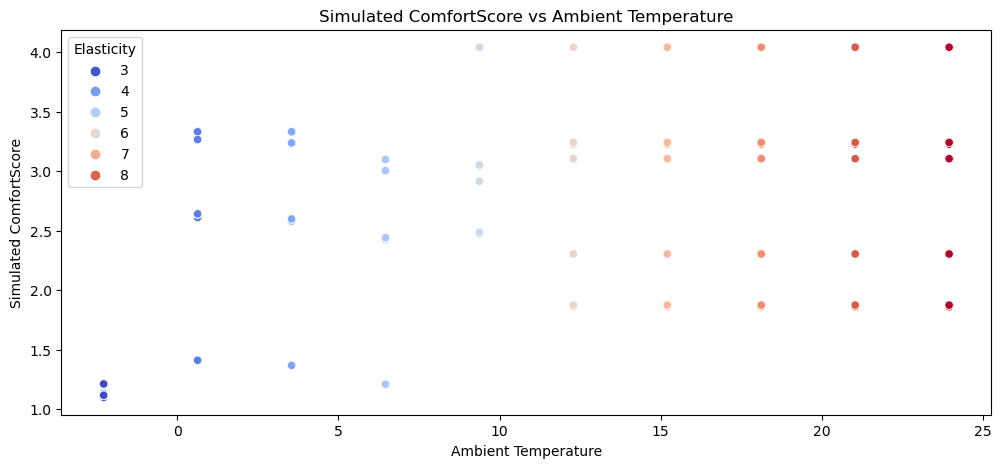

In [7]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=sim_data, x="ambientTemperature", y="SimulatedOutput", hue="elasticity", palette="coolwarm")
plt.title("Simulated ComfortScore vs Ambient Temperature")
plt.xlabel("Ambient Temperature")
plt.ylabel("Simulated ComfortScore")
plt.legend(title="Elasticity")
plt.show()

### Save What-if Analysis Results

In [16]:
sim_data = sim_data.rename(columns={'SimulatedOutput': 'comfortscore'})
df_spark = spark.createDataFrame(sim_data)
df_spark.write.mode("overwrite").format("delta").saveAsTable("what_if_analysis_results")

StatementMeta(, bd22830c-cc3e-4018-8297-4a24c6029c56, 14, Finished, Available, Finished)